#### Import findspark with spark installation path 

In [1]:
import findspark

#### Initialize findspark

In [2]:
findspark.init("/usr/local/spark")

#### Import pyspark

In [3]:
import pyspark

#### Instantiate SparkSession with Hive support

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.appName("capstone").config("spark.sql.warehouse.dir","https://localhost:50070/user/hive/warehouse").enableHiveSupport().getOrCreate()

#### Import necessary libraries

In [6]:
from pyspark.sql import Row
from pyspark.sql import *
from pyspark.sql.types import StructField
from pyspark.sql.types import StructType,StringType
from pyspark.sql import functions as F
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
%matplotlib inline 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics
import missingno as msno
from pyspark_dist_explore import Histogram, hist, distplot

#### Pyspark show dataframe with horizontal scroll

In [7]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Task 3.1 - Data Analysis using Big Data Tools
## Big Data technologies like HDFS, Hive and PySpark need to be used as the historical data increases in size. As part of this task the following activities need to be done.
## ●       Develop a PySpark application to load data Spark DataFrames and save it into Hive tables on a Hadoop cluster in an optimized format.
## ●       Perform profiling of the data through PySpark and ensure that it is migrated correctly whereever the source is an RDBMS
## ●       Write PySpark routines to cleanse the data, prepare the data to handle missing values, and the data transformations identified in task 1.1 again making sure that the data is written into Hive tables in an efficient format
## ●       If the predictive model identified in task 2.4 available in Spark MLlib then develop a PySpark application to implement and evaluate the ML model identified with appropriate metrics\
## ●       Ensure that the best practices are followed and the design & code use the features of Spark and take advantage thereof.

## 1. PySpark application to load data Spark DataFrames and infer the schema

In [8]:
loan_df = spark.read.load('Loan_details_datasets_P5/Loan_details.csv',format='csv',inferSchema="true",header="true")
status_df = spark.read.load('Loan_details_datasets_P5/Loan_status.csv',format='csv',inferSchema="true",header="true")
Branch_df = spark.read.load('Loan_details_datasets_P5/Branch_region_mapping.csv',format='csv',inferSchema="true",header="true")

#### Print the schema of loan_df with its features and their data types

In [9]:
loan_df.printSchema()

root
 |-- Loan_id: integer (nullable = true)
 |-- disbursed_amount: integer (nullable = true)
 |-- asset_cost: integer (nullable = true)
 |-- ltv: double (nullable = true)
 |-- branch_id: integer (nullable = true)
 |-- Date.of.Birth: string (nullable = true)
 |-- Employment.Type: string (nullable = true)
 |-- DisbursalDate: string (nullable = true)
 |-- MobileNo_Avl_Flag: integer (nullable = true)
 |-- Aadhar_flag: integer (nullable = true)
 |-- PAN_flag: integer (nullable = true)
 |-- VoterID_flag: integer (nullable = true)
 |-- Driving_flag: integer (nullable = true)
 |-- Passport_flag: integer (nullable = true)
 |-- PERFORM_CNS.SCORE: integer (nullable = true)
 |-- DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS: integer (nullable = true)
 |-- CREDIT.HISTORY.LENGTH: string (nullable = true)
 |-- NO.OF_INQUIRIES: integer (nullable = true)



#### Show first 3 records from loan_df

In [10]:
loan_df.show(3)

+-------+----------------+----------+-----+---------+-------------+---------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-----------------------------------+---------------------+---------------+
|Loan_id|disbursed_amount|asset_cost|  ltv|branch_id|Date.of.Birth|Employment.Type|DisbursalDate|MobileNo_Avl_Flag|Aadhar_flag|PAN_flag|VoterID_flag|Driving_flag|Passport_flag|PERFORM_CNS.SCORE|DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS|CREDIT.HISTORY.LENGTH|NO.OF_INQUIRIES|
+-------+----------------+----------+-----+---------+-------------+---------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-----------------------------------+---------------------+---------------+
|      1|           36439|     65850|56.19|       64|   14-06-1990|  Self employed|   28-09-2018|                1|          1|       0|           0|           0|            0|                0

#### Print the schema of status_df with its features and their data types

In [11]:
status_df.printSchema()

root
 |-- Loan_id: integer (nullable = true)
 |-- loan_default: integer (nullable = true)



#### Show first 3 records from status_df

In [12]:
status_df.show(3)

+-------+------------+
|Loan_id|loan_default|
+-------+------------+
|      1|           0|
|      2|           0|
|      3|           1|
+-------+------------+
only showing top 3 rows



#### Print the schema of Branch_df with its features and their data types

In [13]:
Branch_df.printSchema()

root
 |-- branch_id: integer (nullable = true)
 |-- region: string (nullable = true)



#### Show first 3 records from Branch_df

In [14]:
Branch_df.show(3)

+---------+------+
|branch_id|region|
+---------+------+
|        1|  East|
|        2|  East|
|        3|  East|
+---------+------+
only showing top 3 rows



#### Creating master dataframe by combining all subsidiary data

In [15]:
master_loan_df=loan_df.join(Branch_df,"branch_id").join(status_df,"loan_id")

#### Print the schema of master_loan_df with its features and their data types

In [16]:
master_loan_df.printSchema()

root
 |-- Loan_id: integer (nullable = true)
 |-- branch_id: integer (nullable = true)
 |-- disbursed_amount: integer (nullable = true)
 |-- asset_cost: integer (nullable = true)
 |-- ltv: double (nullable = true)
 |-- Date.of.Birth: string (nullable = true)
 |-- Employment.Type: string (nullable = true)
 |-- DisbursalDate: string (nullable = true)
 |-- MobileNo_Avl_Flag: integer (nullable = true)
 |-- Aadhar_flag: integer (nullable = true)
 |-- PAN_flag: integer (nullable = true)
 |-- VoterID_flag: integer (nullable = true)
 |-- Driving_flag: integer (nullable = true)
 |-- Passport_flag: integer (nullable = true)
 |-- PERFORM_CNS.SCORE: integer (nullable = true)
 |-- DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS: integer (nullable = true)
 |-- CREDIT.HISTORY.LENGTH: string (nullable = true)
 |-- NO.OF_INQUIRIES: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- loan_default: integer (nullable = true)



#### Show the records of master_loan_df

In [17]:
master_loan_df.show()

+-------+---------+----------------+----------+-----+-------------+---------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-----------------------------------+---------------------+---------------+------+------------+
|Loan_id|branch_id|disbursed_amount|asset_cost|  ltv|Date.of.Birth|Employment.Type|DisbursalDate|MobileNo_Avl_Flag|Aadhar_flag|PAN_flag|VoterID_flag|Driving_flag|Passport_flag|PERFORM_CNS.SCORE|DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS|CREDIT.HISTORY.LENGTH|NO.OF_INQUIRIES|region|loan_default|
+-------+---------+----------------+----------+-----+-------------+---------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-----------------------------------+---------------------+---------------+------+------------+
|      1|       64|           36439|     65850|56.19|   14-06-1990|  Self employed|   28-09-2018|                1|          1|      

#### Display the type of master_loan_df

In [18]:
type(master_loan_df)

pyspark.sql.dataframe.DataFrame

#### Datatypes of all features of master_loan_df

In [19]:
master_loan_df.describe

<bound method DataFrame.describe of DataFrame[Loan_id: int, branch_id: int, disbursed_amount: int, asset_cost: int, ltv: double, Date.of.Birth: string, Employment.Type: string, DisbursalDate: string, MobileNo_Avl_Flag: int, Aadhar_flag: int, PAN_flag: int, VoterID_flag: int, Driving_flag: int, Passport_flag: int, PERFORM_CNS.SCORE: int, DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS: int, CREDIT.HISTORY.LENGTH: string, NO.OF_INQUIRIES: int, region: string, loan_default: int]>

## 2. Save the master_loan_df into Hive tables on a Hadoop cluster in an optimized format

master_loan_df.write.saveAsTable("master")

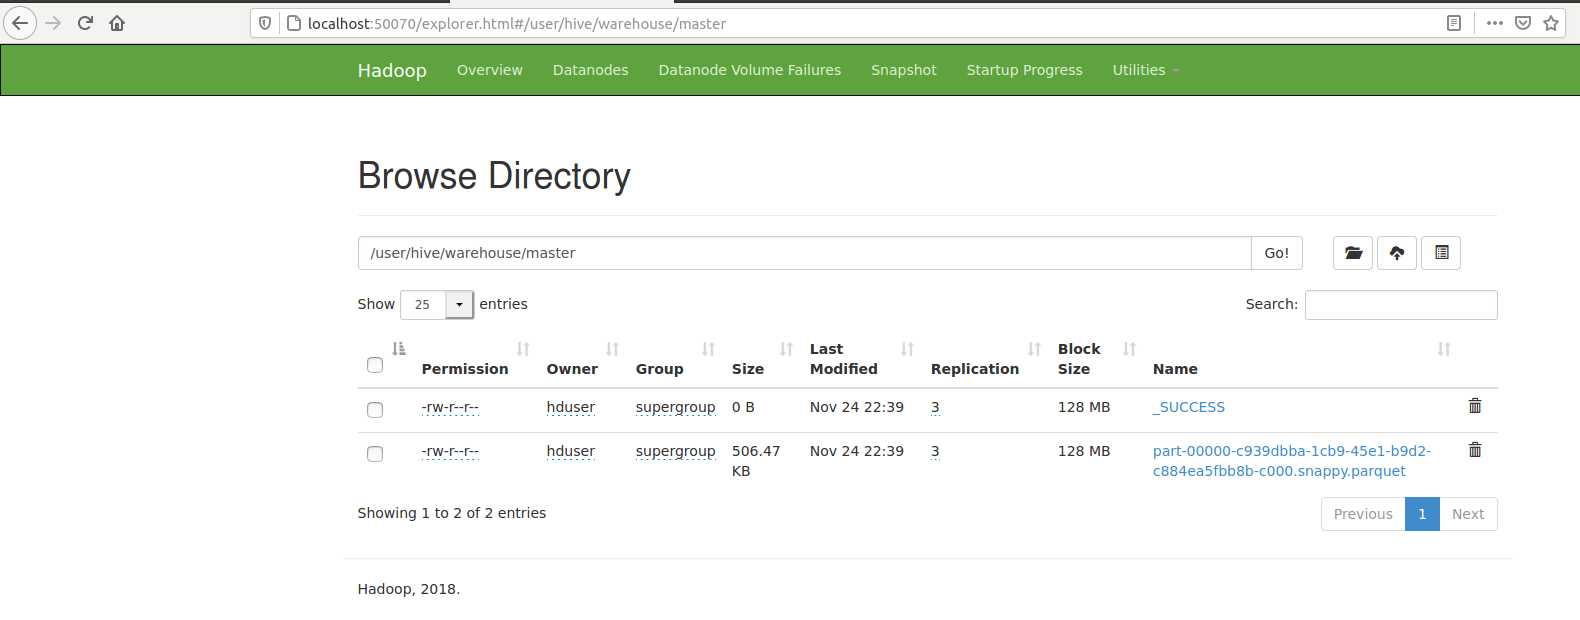

## The optimized format for data storing on a Hadoop cluster is parquet format. Parquet is a compressed columnar data format developed for use in any Hadoop based system. It is supported in spark. 

#### Renaming the columns containing "."

In [20]:
master_loan_df=master_loan_df.withColumnRenamed("Date.of.Birth","DateOfBirth").withColumnRenamed("Employment.Type","EmploymentType").withColumnRenamed("PERFORM_CNS.SCORE","Perform_CNS_score").withColumnRenamed("DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS","Delinquent_accounts").withColumnRenamed("CREDIT.HISTORY.LENGTH","Credit_History_Length").withColumnRenamed("NO.OF_INQUIRIES","No_of_inquiries")

#### Printing the schema of master_loan_df

In [21]:
master_loan_df.printSchema()

root
 |-- Loan_id: integer (nullable = true)
 |-- branch_id: integer (nullable = true)
 |-- disbursed_amount: integer (nullable = true)
 |-- asset_cost: integer (nullable = true)
 |-- ltv: double (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- EmploymentType: string (nullable = true)
 |-- DisbursalDate: string (nullable = true)
 |-- MobileNo_Avl_Flag: integer (nullable = true)
 |-- Aadhar_flag: integer (nullable = true)
 |-- PAN_flag: integer (nullable = true)
 |-- VoterID_flag: integer (nullable = true)
 |-- Driving_flag: integer (nullable = true)
 |-- Passport_flag: integer (nullable = true)
 |-- Perform_CNS_score: integer (nullable = true)
 |-- Delinquent_accounts: integer (nullable = true)
 |-- Credit_History_Length: string (nullable = true)
 |-- No_of_inquiries: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- loan_default: integer (nullable = true)



## 3. Perform profiling of the data through PySpark 

#### Describe the statistical measures of the numerical features of master_loan_df by converting it to Pandas dataframe

In [22]:
master_loan_df.toPandas().describe()

Loan_id     branch_id  disbursed_amount     asset_cost  \
count  23315.000000  23315.000000      23315.000000   23315.000000   
mean   11658.000000     72.079262      54297.647309   75842.182887   
std     6730.605099     69.095008      13061.877434   18988.525635   
min        1.000000      1.000000      13369.000000   37230.000000   
25%     5829.500000     13.000000      46949.000000   65629.000000   
50%    11658.000000     61.000000      53759.000000   70929.000000   
75%    17486.500000    121.000000      60379.000000   79354.500000   
max    23315.000000    261.000000     592460.000000  715186.000000   

                ltv  MobileNo_Avl_Flag   Aadhar_flag      PAN_flag  \
count  23315.000000            23315.0  23315.000000  23315.000000   
mean      74.701607                1.0      0.845078      0.075531   
std       11.462722                0.0      0.361838      0.264252   
min       17.130000                1.0      0.000000      0.000000   
25%       68.830000                1.0      1.000000      0.000000   
50%       76.710000                1.0      1.000000      0.000000   
75%       83.630000                1.0      1.000000      0.000000   
max       94.980000                1.0      1.000000      1.000000   

       VoterID_flag  Driving_flag  Passport_flag  Perform_CNS_score  \
count  23315.000000  23315.000000   23315.000000       23315.000000   
mean       0.141068      0.023161       0.002059         291.234956   
std        0.348099      0.150418       0.045328         338.490214   
min        0.000000      0.000000       0.000000           0.000000   
25%        0.000000      0.000000       0.000000           0.000000   
50%        0.000000      0.000000       0.000000           0.000000   
75%        0.000000      0.000000       0.000000         679.000000   
max        1.000000      1.000000       1.000000         890.000000   

       Delinquent_accounts  No_of_inquiries  loan_default  
count         23315.000000     23315.000000  23315.000000  
mean              0.100622         0.205790      0.219858  
std               0.388782         0.699901      0.414159  
min               0.000000         0.000000      0.000000  
25%               0.000000         0.000000      0.000000  
50%               0.000000         0.000000      0.000000  
75%               0.000000         0.000000      0.000000  
max               7.000000        23.000000      1.000000

#### Creates or replaces a local temporary view with this DataFrame. Register the dataframe as a SQL temporary view.

In [23]:
master_loan_df.createOrReplaceTempView("master")

In [24]:
type(master_loan_df)

pyspark.sql.dataframe.DataFrame

#### Profiling the data

In [25]:
master_loan_temp=spark.sql('select * from master')

In [26]:
type(master_loan_temp)

pyspark.sql.dataframe.DataFrame

In [27]:
master_loan_temp.describe

<bound method DataFrame.describe of DataFrame[Loan_id: int, branch_id: int, disbursed_amount: int, asset_cost: int, ltv: double, DateOfBirth: string, EmploymentType: string, DisbursalDate: string, MobileNo_Avl_Flag: int, Aadhar_flag: int, PAN_flag: int, VoterID_flag: int, Driving_flag: int, Passport_flag: int, Perform_CNS_score: int, Delinquent_accounts: int, Credit_History_Length: string, No_of_inquiries: int, region: string, loan_default: int]>

In [28]:
master_loan_temp.show(3)

+-------+---------+----------------+----------+-----+-----------+--------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------------+---------------+------+------------+
|Loan_id|branch_id|disbursed_amount|asset_cost|  ltv|DateOfBirth|EmploymentType|DisbursalDate|MobileNo_Avl_Flag|Aadhar_flag|PAN_flag|VoterID_flag|Driving_flag|Passport_flag|Perform_CNS_score|Delinquent_accounts|Credit_History_Length|No_of_inquiries|region|loan_default|
+-------+---------+----------------+----------+-----+-----------+--------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------------+---------------+------+------------+
|      1|       64|           36439|     65850|56.19| 14-06-1990| Self employed|   28-09-2018|                1|          1|       0|           0|           0|            0|                0

#### Describing the summary statistics for all features using the in-built function.

In [29]:
master_loan_statistics=master_loan_temp.describe()
master_loan_statistics.show()

+-------+-----------------+-----------------+-----------------+-----------------+------------------+-----------+--------------+-------------+-----------------+------------------+-------------------+-------------------+--------------------+--------------------+-----------------+-------------------+---------------------+-------------------+------+-------------------+
|summary|          Loan_id|        branch_id| disbursed_amount|       asset_cost|               ltv|DateOfBirth|EmploymentType|DisbursalDate|MobileNo_Avl_Flag|       Aadhar_flag|           PAN_flag|       VoterID_flag|        Driving_flag|       Passport_flag|Perform_CNS_score|Delinquent_accounts|Credit_History_Length|    No_of_inquiries|region|       loan_default|
+-------+-----------------+-----------------+-----------------+-----------------+------------------+-----------+--------------+-------------+-----------------+------------------+-------------------+-------------------+--------------------+--------------------+----

#### Selecting all columns in the dataframe for data profiling

In [30]:
profile_cols=master_loan_temp.columns

In [31]:
profile_cols

['Loan_id',
 'branch_id',
 'disbursed_amount',
 'asset_cost',
 'ltv',
 'DateOfBirth',
 'EmploymentType',
 'DisbursalDate',
 'MobileNo_Avl_Flag',
 'Aadhar_flag',
 'PAN_flag',
 'VoterID_flag',
 'Driving_flag',
 'Passport_flag',
 'Perform_CNS_score',
 'Delinquent_accounts',
 'Credit_History_Length',
 'No_of_inquiries',
 'region',
 'loan_default']

#### Displaying the data types of profile_cols

In [32]:
master_loan_temp.dtypes

[('Loan_id', 'int'),
 ('branch_id', 'int'),
 ('disbursed_amount', 'int'),
 ('asset_cost', 'int'),
 ('ltv', 'double'),
 ('DateOfBirth', 'string'),
 ('EmploymentType', 'string'),
 ('DisbursalDate', 'string'),
 ('MobileNo_Avl_Flag', 'int'),
 ('Aadhar_flag', 'int'),
 ('PAN_flag', 'int'),
 ('VoterID_flag', 'int'),
 ('Driving_flag', 'int'),
 ('Passport_flag', 'int'),
 ('Perform_CNS_score', 'int'),
 ('Delinquent_accounts', 'int'),
 ('Credit_History_Length', 'string'),
 ('No_of_inquiries', 'int'),
 ('region', 'string'),
 ('loan_default', 'int')]

#### Creating a Pandas dataframe for profiled data

In [33]:
master_loan_profile = pd.DataFrame({'Features':profile_cols,'data_types':[dt[1] for dt in master_loan_temp.dtypes]}) 

In [34]:
master_loan_profile

Features data_types
0                 Loan_id        int
1               branch_id        int
2        disbursed_amount        int
3              asset_cost        int
4                     ltv     double
5             DateOfBirth     string
6          EmploymentType     string
7           DisbursalDate     string
8       MobileNo_Avl_Flag        int
9             Aadhar_flag        int
10               PAN_flag        int
11           VoterID_flag        int
12           Driving_flag        int
13          Passport_flag        int
14      Perform_CNS_score        int
15    Delinquent_accounts        int
16  Credit_History_Length     string
17        No_of_inquiries        int
18                 region     string
19           loan_default        int

#### Find the total number of rows in the dataframe

In [35]:
rows = master_loan_temp.count()
rows

23315

#### Finding the null values or missing values for each feature of the dataframe and merging the column of Missing_values to the profiled dataframe.


In [36]:
count_nan = master_loan_temp.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in profile_cols]).toPandas().transpose()
count_nan = count_nan.reset_index()  
count_nan.columns = ['Features','Missing_values']
master_loan_profile = pd.merge(master_loan_profile,count_nan, on = ['Features'], how = 'left')

In [37]:
master_loan_profile 

Features data_types  Missing_values
0                 Loan_id        int               0
1               branch_id        int               0
2        disbursed_amount        int               0
3              asset_cost        int               0
4                     ltv     double               0
5             DateOfBirth     string               0
6          EmploymentType     string             770
7           DisbursalDate     string               0
8       MobileNo_Avl_Flag        int               0
9             Aadhar_flag        int               0
10               PAN_flag        int               0
11           VoterID_flag        int               0
12           Driving_flag        int               0
13          Passport_flag        int               0
14      Perform_CNS_score        int               0
15    Delinquent_accounts        int               0
16  Credit_History_Length     string               0
17        No_of_inquiries        int               0
18                 region     string               0
19           loan_default        int               0

#### Merging the master_loan_statistics with master_loan_profile to create a profiled dataframe of statistical measures for the features.

In [38]:
master_loan_statistics_desc=master_loan_statistics.toPandas().transpose()
master_loan_statistics_desc

0                      1                     2  \
summary                count                   mean                stddev   
Loan_id                23315                11658.0     6730.605099097703   
branch_id              23315      72.07926227750376     69.09500824842503   
disbursed_amount       23315      54297.64730859961     13061.87743441026   
asset_cost             23315      75842.18288655372     18988.52563450024   
ltv                    23315      74.70160669097099    11.462722365672377   
DateOfBirth            23315                   None                  None   
EmploymentType         22545                   None                  None   
DisbursalDate          23315                   None                  None   
MobileNo_Avl_Flag      23315                    1.0                   0.0   
Aadhar_flag            23315     0.8450782757881192    0.3618378077692845   
PAN_flag               23315    0.07553077417971263   0.26425153046041194   
VoterID_flag           23315    0.14106798198584602   0.34809912906604457   
Driving_flag           23315   0.023161055114733004    0.1504180543398142   
Passport_flag          23315  0.0020587604546429337  0.045327806962078915   
Perform_CNS_score      23315      291.2349560368861       338.49021363711   
Delinquent_accounts    23315    0.10062191722067339    0.3887817919189767   
Credit_History_Length  23315                   None                  None   
No_of_inquiries        23315    0.20579026377868326     0.699900675387826   
region                 23315                   None                  None   
loan_default           23315     0.2198584602187433   0.41415947975710266   

                                3              4  
summary                       min            max  
Loan_id                         1          23315  
branch_id                       1            261  
disbursed_amount            13369         592460  
asset_cost                  37230         715186  
ltv                         17.13          94.98  
DateOfBirth            01-01-1955     31-12-1997  
EmploymentType           Salaried  Self employed  
DisbursalDate          01-08-2018     31-10-2018  
MobileNo_Avl_Flag               1              1  
Aadhar_flag                     0              1  
PAN_flag                        0              1  
VoterID_flag                    0              1  
Driving_flag                    0              1  
Passport_flag                   0              1  
Perform_CNS_score               0            890  
Delinquent_accounts             0              7  
Credit_History_Length   0yrs 0mon      9yrs 9mon  
No_of_inquiries                 0             23  
region                       East           West  
loan_default                    0              1

In [39]:
master_loan_statistics_desc.columns = ['count', 'mean', 'stddev', 'min', 'max']
master_loan_statistics_desc= master_loan_statistics_desc.iloc[1:,:]  
master_loan_statistics_desc= master_loan_statistics_desc.reset_index()  
master_loan_statistics_desc.columns.values[0] = 'Features' 
master_loan_statistics_desc = master_loan_statistics_desc[['Features','count', 'mean', 'stddev']] 
master_loan_profile= pd.merge(master_loan_profile, master_loan_statistics_desc , on = ['Features'], how = 'left')

In [40]:
allminvalues = [master_loan_temp.select(F.min(x)).limit(1).toPandas().iloc[0][0] for x in profile_cols]
allmaxvalues = [master_loan_temp.select(F.max(x)).limit(1).toPandas().iloc[0][0] for x in profile_cols]
df_counts =master_loan_profile[['Features']]
df_counts.insert(loc=0, column='min', value=allminvalues)
df_counts.insert(loc=0, column='max', value=allmaxvalues)
df_counts = df_counts[['Features','min','max']]
master_loan_profile = pd.merge(master_loan_profile, df_counts , on = ['Features'], how = 'left')  

In [41]:
master_loan_profile

Features data_types  Missing_values  count  \
0                 Loan_id        int               0  23315   
1               branch_id        int               0  23315   
2        disbursed_amount        int               0  23315   
3              asset_cost        int               0  23315   
4                     ltv     double               0  23315   
5             DateOfBirth     string               0  23315   
6          EmploymentType     string             770  22545   
7           DisbursalDate     string               0  23315   
8       MobileNo_Avl_Flag        int               0  23315   
9             Aadhar_flag        int               0  23315   
10               PAN_flag        int               0  23315   
11           VoterID_flag        int               0  23315   
12           Driving_flag        int               0  23315   
13          Passport_flag        int               0  23315   
14      Perform_CNS_score        int               0  23315   
15    Delinquent_accounts        int               0  23315   
16  Credit_History_Length     string               0  23315   
17        No_of_inquiries        int               0  23315   
18                 region     string               0  23315   
19           loan_default        int               0  23315   

                     mean                stddev         min            max  
0                 11658.0     6730.605099097703           1          23315  
1       72.07926227750376     69.09500824842503           1            261  
2       54297.64730859961     13061.87743441026       13369         592460  
3       75842.18288655372     18988.52563450024       37230         715186  
4       74.70160669097099    11.462722365672377       17.13          94.98  
5                    None                  None  01-01-1955     31-12-1997  
6                    None                  None    Salaried  Self employed  
7                    None                  None  01-08-2018     31-10-2018  
8                     1.0                   0.0           1              1  
9      0.8450782757881192    0.3618378077692845           0              1  
10    0.07553077417971263   0.26425153046041194           0              1  
11    0.14106798198584602   0.34809912906604457           0              1  
12   0.023161055114733004    0.1504180543398142           0              1  
13  0.0020587604546429337  0.045327806962078915           0              1  
14      291.2349560368861       338.49021363711           0            890  
15    0.10062191722067339    0.3887817919189767           0              7  
16                   None                  None   0yrs 0mon      9yrs 9mon  
17    0.20579026377868326     0.699900675387826           0             23  
18                   None                  None        East           West  
19     0.2198584602187433   0.41415947975710266           0              1

#### Finding the count of distinct values for each feature

In [42]:
master_loan_profile['num_distinct'] = [master_loan_temp.select(x).distinct().count() for x in profile_cols]

#### Final data profile

In [43]:
master_loan_profile

Features data_types  Missing_values  count  \
0                 Loan_id        int               0  23315   
1               branch_id        int               0  23315   
2        disbursed_amount        int               0  23315   
3              asset_cost        int               0  23315   
4                     ltv     double               0  23315   
5             DateOfBirth     string               0  23315   
6          EmploymentType     string             770  22545   
7           DisbursalDate     string               0  23315   
8       MobileNo_Avl_Flag        int               0  23315   
9             Aadhar_flag        int               0  23315   
10               PAN_flag        int               0  23315   
11           VoterID_flag        int               0  23315   
12           Driving_flag        int               0  23315   
13          Passport_flag        int               0  23315   
14      Perform_CNS_score        int               0  23315   
15    Delinquent_accounts        int               0  23315   
16  Credit_History_Length     string               0  23315   
17        No_of_inquiries        int               0  23315   
18                 region     string               0  23315   
19           loan_default        int               0  23315   

                     mean                stddev         min            max  \
0                 11658.0     6730.605099097703           1          23315   
1       72.07926227750376     69.09500824842503           1            261   
2       54297.64730859961     13061.87743441026       13369         592460   
3       75842.18288655372     18988.52563450024       37230         715186   
4       74.70160669097099    11.462722365672377       17.13          94.98   
5                    None                  None  01-01-1955     31-12-1997   
6                    None                  None    Salaried  Self employed   
7                    None                  None  01-08-2018     31-10-2018   
8                     1.0                   0.0           1              1   
9      0.8450782757881192    0.3618378077692845           0              1   
10    0.07553077417971263   0.26425153046041194           0              1   
11    0.14106798198584602   0.34809912906604457           0              1   
12   0.023161055114733004    0.1504180543398142           0              1   
13  0.0020587604546429337  0.045327806962078915           0              1   
14      291.2349560368861       338.49021363711           0            890   
15    0.10062191722067339    0.3887817919189767           0              7   
16                   None                  None   0yrs 0mon      9yrs 9mon   
17    0.20579026377868326     0.699900675387826           0             23   
18                   None                  None        East           West   
19     0.2198584602187433   0.41415947975710266           0              1   

    num_distinct  
0          23315  
1             82  
2           6057  
3          13886  
4           4527  
5           8729  
6              3  
7             84  
8              1  
9              2  
10             2  
11             2  
12             2  
13             2  
14           537  
15             8  
16           212  
17            14  
18             4  
19             2

In [44]:
type(master_loan_profile)

pandas.core.frame.DataFrame

## 4. Ensure that the profiled data through Pyspark is migrated correctly whereever the source is an RDBMS

#### Converting the pandas dataframe to spark dataframe

In [45]:
master_loan_profile_sparkDF=spark.createDataFrame(master_loan_profile.astype(str)) 

#### Migrating the data

In [46]:
master_loan_profile_sparkDF.select("*").show()

+--------------------+----------+--------------+-----+--------------------+--------------------+----------+-------------+------------+
|            Features|data_types|Missing_values|count|                mean|              stddev|       min|          max|num_distinct|
+--------------------+----------+--------------+-----+--------------------+--------------------+----------+-------------+------------+
|             Loan_id|       int|             0|23315|             11658.0|   6730.605099097703|         1|        23315|       23315|
|           branch_id|       int|             0|23315|   72.07926227750376|   69.09500824842503|         1|          261|          82|
|    disbursed_amount|       int|             0|23315|   54297.64730859961|   13061.87743441026|     13369|       592460|        6057|
|          asset_cost|       int|             0|23315|   75842.18288655372|   18988.52563450024|     37230|       715186|       13886|
|                 ltv|    double|             0|23315| 

#### Convert the spark dataframe to a temp table for querying

In [47]:
master_loan_profile_sparkDF.registerTempTable("master_loan_profile_table")

#### Performing a query operation on above table for finding the missing values

In [48]:
spark.sql('select Features, data_types, Missing_values, count, num_distinct from master_loan_profile_table where Missing_values>0').show()

+--------------+----------+--------------+-----+------------+
|      Features|data_types|Missing_values|count|num_distinct|
+--------------+----------+--------------+-----+------------+
|EmploymentType|    string|           770|22545|           3|
+--------------+----------+--------------+-----+------------+



## 5. Write PySpark routines to cleanse the data, prepare the data to handle missing values, and the data transformations identified in task 1.1 again making sure that the data is written into Hive tables in an efficient format

#### Finding the missing values for data cleaning

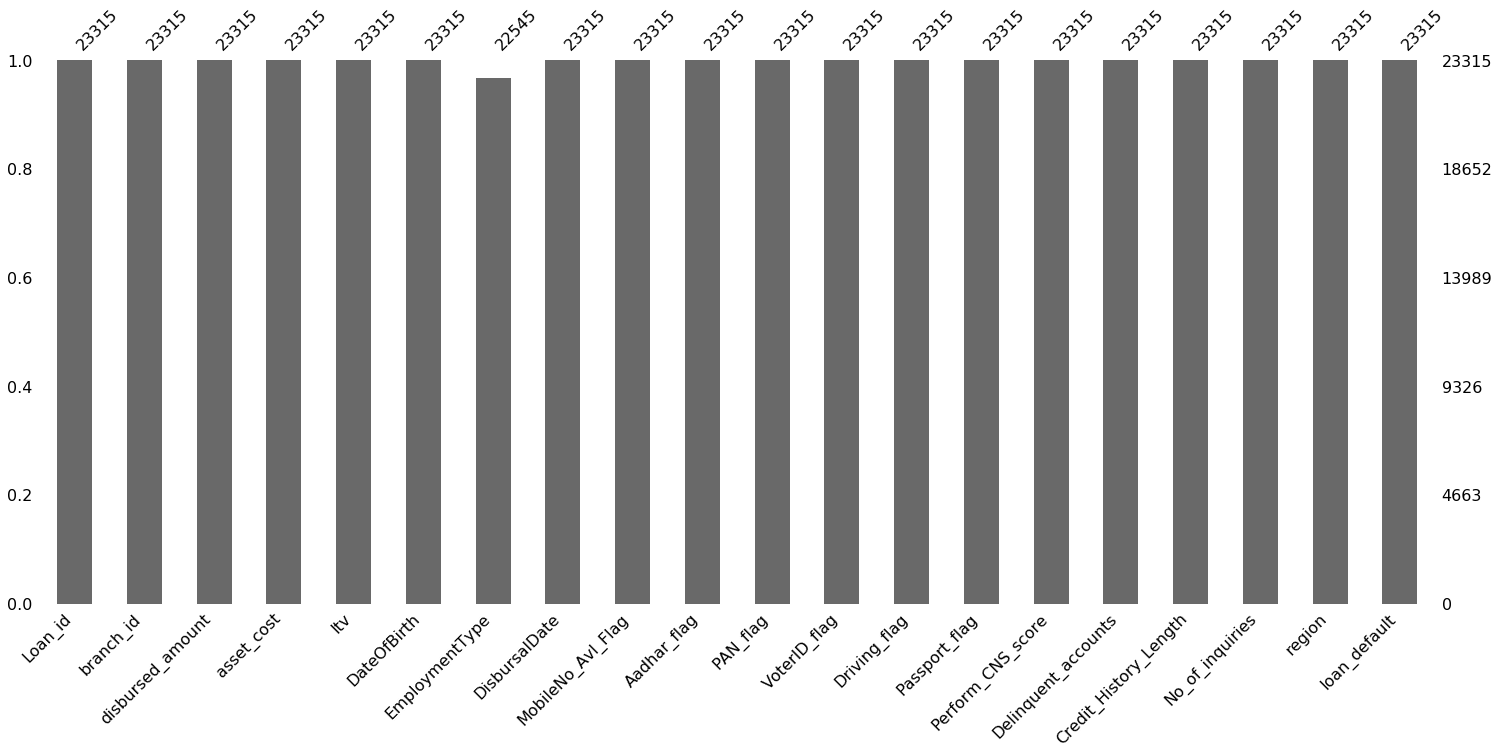

In [49]:
msno.bar(master_loan_df.toPandas())

## The above bar plot shows that there are 23315-22545=770 missing values for EmploymentType in the given dataset.

In [50]:
msno.matrix(master_loan_df.toPandas())

#### The above matrix shows the Loan_id's which have the missing values for EmploymentType.

#### Missing value treatment

In [51]:
master_loan_temp=master_loan_temp.na.fill({'EmploymentType':'Unemployed'})
master_loan_temp

DataFrame[Loan_id: int, branch_id: int, disbursed_amount: int, asset_cost: int, ltv: double, DateOfBirth: string, EmploymentType: string, DisbursalDate: string, MobileNo_Avl_Flag: int, Aadhar_flag: int, PAN_flag: int, VoterID_flag: int, Driving_flag: int, Passport_flag: int, Perform_CNS_score: int, Delinquent_accounts: int, Credit_History_Length: string, No_of_inquiries: int, region: string, loan_default: int]

In [52]:
categories=master_loan_temp.groupBy('EmploymentType').count().show()
categories

+--------------+-----+
|EmploymentType|count|
+--------------+-----+
| Self employed|12724|
|      Salaried| 9821|
|    Unemployed|  770|
+--------------+-----+



## The missing values in EmploymentType have been replaced with Unemployed.

#### Target variable distribution-assessing the data based on defaulted status

In [53]:
master_loan_temp.groupBy('loan_default').count().withColumnRenamed('count','Group_count').withColumn('Percentage', (F.col('Group_count') / rows) * 100 ).show()

+------------+-----------+-----------------+
|loan_default|Group_count|       Percentage|
+------------+-----------+-----------------+
|           1|       5126|21.98584602187433|
|           0|      18189|78.01415397812566|
+------------+-----------+-----------------+



## It suggests that the majority of the data belongs to the NotDefaulted category which may lead to majority oversampling if the whole dataset is considered for training the model.

#### Data Transformation

#### Convert dataframe to Resilient Distributed Dataset (RDD)

In [54]:
master_loan_rdd=master_loan_temp.rdd

In [55]:
type(master_loan_rdd)

pyspark.rdd.RDD

#### Return all the elements of the dataset

In [56]:
master_loan_rdd.collect()

[Row(Loan_id=1, branch_id=64, disbursed_amount=36439, asset_cost=65850, ltv=56.19, DateOfBirth='14-06-1990', EmploymentType='Self employed', DisbursalDate='28-09-2018', MobileNo_Avl_Flag=1, Aadhar_flag=1, PAN_flag=0, VoterID_flag=0, Driving_flag=0, Passport_flag=0, Perform_CNS_score=0, Delinquent_accounts=0, Credit_History_Length='0yrs 0mon', No_of_inquiries=0, region='South', loan_default=0),
 Row(Loan_id=2, branch_id=67, disbursed_amount=48749, asset_cost=69303, ltv=72.15, DateOfBirth='01-01-1991', EmploymentType='Salaried', DisbursalDate='10-09-2018', MobileNo_Avl_Flag=1, Aadhar_flag=1, PAN_flag=0, VoterID_flag=0, Driving_flag=0, Passport_flag=0, Perform_CNS_score=783, Delinquent_accounts=0, Credit_History_Length='2yrs 6mon', No_of_inquiries=0, region='South', loan_default=0),
 Row(Loan_id=3, branch_id=2, disbursed_amount=55348, asset_cost=66340, ltv=85.0, DateOfBirth='16-08-1993', EmploymentType='Self employed', DisbursalDate='31-08-2018', MobileNo_Avl_Flag=1, Aadhar_flag=1, PAN_fl

#### Count the number of rows in the dataframe

In [57]:
master_loan_rdd.count()

23315

#### Return an array with the first 5 elements of the dataset

In [58]:
master_loan_rdd.take(5)

[Row(Loan_id=1, branch_id=64, disbursed_amount=36439, asset_cost=65850, ltv=56.19, DateOfBirth='14-06-1990', EmploymentType='Self employed', DisbursalDate='28-09-2018', MobileNo_Avl_Flag=1, Aadhar_flag=1, PAN_flag=0, VoterID_flag=0, Driving_flag=0, Passport_flag=0, Perform_CNS_score=0, Delinquent_accounts=0, Credit_History_Length='0yrs 0mon', No_of_inquiries=0, region='South', loan_default=0),
 Row(Loan_id=2, branch_id=67, disbursed_amount=48749, asset_cost=69303, ltv=72.15, DateOfBirth='01-01-1991', EmploymentType='Salaried', DisbursalDate='10-09-2018', MobileNo_Avl_Flag=1, Aadhar_flag=1, PAN_flag=0, VoterID_flag=0, Driving_flag=0, Passport_flag=0, Perform_CNS_score=783, Delinquent_accounts=0, Credit_History_Length='2yrs 6mon', No_of_inquiries=0, region='South', loan_default=0),
 Row(Loan_id=3, branch_id=2, disbursed_amount=55348, asset_cost=66340, ltv=85.0, DateOfBirth='16-08-1993', EmploymentType='Self employed', DisbursalDate='31-08-2018', MobileNo_Avl_Flag=1, Aadhar_flag=1, PAN_fl

#### Return rows having EmploymentType as Self employed

In [59]:
master_loan_temp.filter(master_loan_temp['EmploymentType'] =='Self employed').show()

+-------+---------+----------------+----------+-----+-----------+--------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------------+---------------+------+------------+
|Loan_id|branch_id|disbursed_amount|asset_cost|  ltv|DateOfBirth|EmploymentType|DisbursalDate|MobileNo_Avl_Flag|Aadhar_flag|PAN_flag|VoterID_flag|Driving_flag|Passport_flag|Perform_CNS_score|Delinquent_accounts|Credit_History_Length|No_of_inquiries|region|loan_default|
+-------+---------+----------------+----------+-----+-----------+--------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------------+---------------+------+------------+
|      1|       64|           36439|     65850|56.19| 14-06-1990| Self employed|   28-09-2018|                1|          1|       0|           0|           0|            0|                0

#### Return rows where region starts with S

In [60]:
master_loan_temp.filter(master_loan_temp.region.like('S%')).show()

+-------+---------+----------------+----------+-----+-----------+--------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------------+---------------+------+------------+
|Loan_id|branch_id|disbursed_amount|asset_cost|  ltv|DateOfBirth|EmploymentType|DisbursalDate|MobileNo_Avl_Flag|Aadhar_flag|PAN_flag|VoterID_flag|Driving_flag|Passport_flag|Perform_CNS_score|Delinquent_accounts|Credit_History_Length|No_of_inquiries|region|loan_default|
+-------+---------+----------------+----------+-----+-----------+--------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------------+---------------+------+------------+
|      1|       64|           36439|     65850|56.19| 14-06-1990| Self employed|   28-09-2018|                1|          1|       0|           0|           0|            0|                0

## Data Visualizations

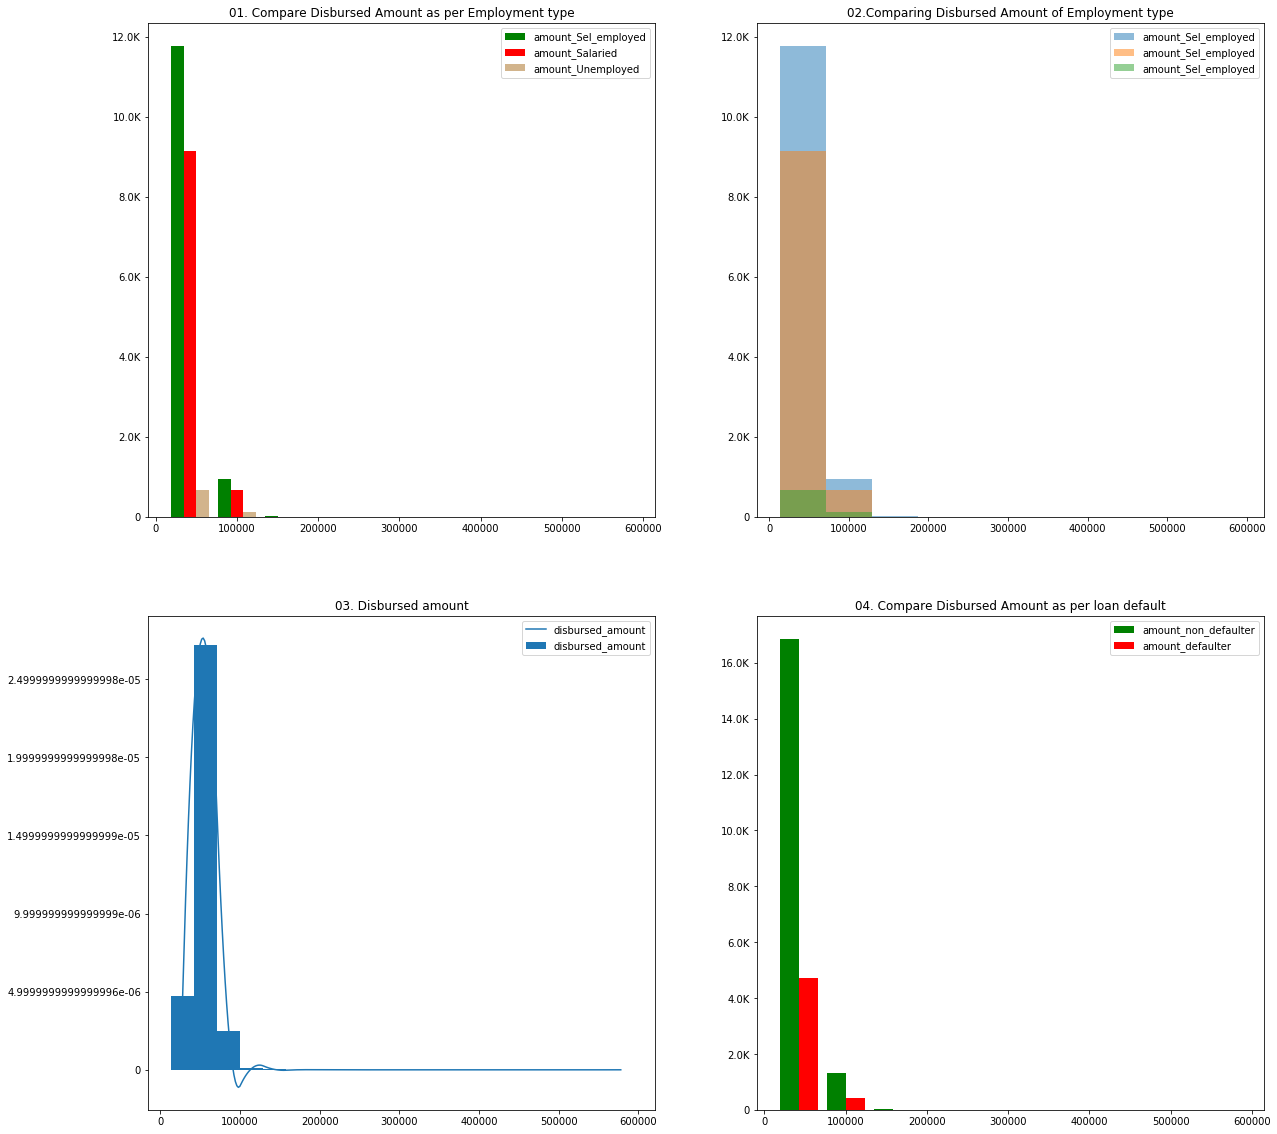

In [61]:
filtered_by_emp_self = master_loan_temp.filter(F.col('EmploymentType') == 'Self employed').select(F.col('disbursed_amount').alias('amount_Sel_employed'))
filtered_by_emp_salary = master_loan_temp.filter(F.col('EmploymentType') == 'Salaried').select(F.col('disbursed_amount').alias('amount_Salaried') )                                                                            
filtered_by_emp_Unemployed = master_loan_temp.filter(F.col('EmploymentType') == 'Unemployed').select(F.col('disbursed_amount').alias('amount_Unemployed') )      
filtered_by_loandefault_0 = master_loan_temp.filter(F.col('loan_default') == 0).select(F.col('disbursed_amount').alias('amount_non_defaulter') )
filtered_by_loandefault_1 = master_loan_temp.filter(F.col('loan_default') == 1).select(F.col('disbursed_amount').alias('amount_defaulter') )
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(20, 20)
hist(axes[0, 0], [filtered_by_emp_self, filtered_by_emp_salary, filtered_by_emp_Unemployed], bins = 10, color=['green','red', 'tan'])
axes[0, 0].set_title('01. Compare Disbursed Amount as per Employment type')
axes[0, 0].legend()
hist(axes[0, 1], [filtered_by_emp_self, filtered_by_emp_salary, filtered_by_emp_Unemployed], overlapping=True)
axes[0, 1].set_title('02.Comparing Disbursed Amount of Employment type')
axes[0, 1].legend()
distplot(axes[1, 0], master_loan_temp.select('disbursed_amount'), bins=20)
axes[1, 0].set_title('03. Disbursed amount')
axes[1, 0].legend()
hist(axes[1, 1], [filtered_by_loandefault_0, filtered_by_loandefault_1], bins = 10, color=['green','red'])
axes[1, 1].set_title('04. Compare Disbursed Amount as per loan default')
axes[1, 1].legend()

#### One-hot encoding for categorical variables

In [62]:
from pyspark.ml import Pipeline
indexer = [StringIndexer(inputCol="EmploymentType", outputCol="EmploymentTypeIndex"),StringIndexer(inputCol="region", outputCol="regionIndex")]
pipeline = Pipeline(stages=indexer)
master_loan_temp = pipeline.fit(master_loan_temp).transform(master_loan_temp)
master_loan_temp.show()

+-------+---------+----------------+----------+-----+-----------+--------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------------+---------------+------+------------+-------------------+-----------+
|Loan_id|branch_id|disbursed_amount|asset_cost|  ltv|DateOfBirth|EmploymentType|DisbursalDate|MobileNo_Avl_Flag|Aadhar_flag|PAN_flag|VoterID_flag|Driving_flag|Passport_flag|Perform_CNS_score|Delinquent_accounts|Credit_History_Length|No_of_inquiries|region|loan_default|EmploymentTypeIndex|regionIndex|
+-------+---------+----------------+----------+-----+-----------+--------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------------+---------------+------+------------+-------------------+-----------+
|      1|       64|           36439|     65850|56.19| 14-06-1990| Self employed|   28-09-2018|

In [63]:
master_loan_temp.show()

+-------+---------+----------------+----------+-----+-----------+--------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------------+---------------+------+------------+-------------------+-----------+
|Loan_id|branch_id|disbursed_amount|asset_cost|  ltv|DateOfBirth|EmploymentType|DisbursalDate|MobileNo_Avl_Flag|Aadhar_flag|PAN_flag|VoterID_flag|Driving_flag|Passport_flag|Perform_CNS_score|Delinquent_accounts|Credit_History_Length|No_of_inquiries|region|loan_default|EmploymentTypeIndex|regionIndex|
+-------+---------+----------------+----------+-----+-----------+--------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------------+---------------+------+------------+-------------------+-----------+
|      1|       64|           36439|     65850|56.19| 14-06-1990| Self employed|   28-09-2018|

In [64]:
master_loan_df.groupby("loan_default").count().show()

+------------+-----+
|loan_default|count|
+------------+-----+
|           1| 5126|
|           0|18189|
+------------+-----+



#### Check for null values

In [65]:
master_loan_temp.select([count(when(isnan(c), c)).alias(c) for c in master_loan_temp.columns]).toPandas().head()

Loan_id  branch_id  disbursed_amount  asset_cost  ltv  DateOfBirth  \
0        0          0                 0           0    0            0   

   EmploymentType  DisbursalDate  MobileNo_Avl_Flag  Aadhar_flag  ...  \
0               0              0                  0            0  ...   

   Driving_flag  Passport_flag  Perform_CNS_score  Delinquent_accounts  \
0             0              0                  0                    0   

   Credit_History_Length  No_of_inquiries  region  loan_default  \
0                      0                0       0             0   

   EmploymentTypeIndex  regionIndex  
0                    0            0  

[1 rows x 22 columns]

#### Pearson Correlation

In [66]:
numeric_features = [t[0] for t in master_loan_temp.dtypes if t[1] != 'string']
numeric_features_temp=master_loan_temp.select(numeric_features)
numeric_features_temp.toPandas().head()

Loan_id  branch_id  disbursed_amount  asset_cost    ltv  MobileNo_Avl_Flag  \
0        1         64             36439       65850  56.19                  1   
1        2         67             48749       69303  72.15                  1   
2        3          2             55348       66340  85.00                  1   
3        4        217             48849       64133  77.96                  1   
4        5         74             40394       59386  70.72                  1   

   Aadhar_flag  PAN_flag  VoterID_flag  Driving_flag  Passport_flag  \
0            1         0             0             0              0   
1            1         0             0             0              0   
2            1         0             0             0              0   
3            1         0             0             0              0   
4            1         0             0             0              0   

   Perform_CNS_score  Delinquent_accounts  No_of_inquiries  loan_default  \
0                  0                    0                0             0   
1                783                    0                0             0   
2                  0                    0                0             1   
3                  0                    0                0             0   
4                 14                    1                1             0   

   EmploymentTypeIndex  regionIndex  
0                  0.0          1.0  
1                  1.0          1.0  
2                  0.0          0.0  
3                  0.0          3.0  
4                  0.0          1.0

In [67]:
col_names =numeric_features_temp.columns
features = numeric_features_temp.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
corr_df

Loan_id  branch_id  disbursed_amount  asset_cost  \
Loan_id              1.000000   0.001564         -0.006935   -0.003720   
branch_id            0.001564   1.000000          0.024890    0.023997   
disbursed_amount    -0.006935   0.024890          1.000000    0.752629   
asset_cost          -0.003720   0.023997          0.752629    1.000000   
ltv                 -0.005458   0.010844          0.372385   -0.304288   
MobileNo_Avl_Flag         NaN        NaN               NaN         NaN   
Aadhar_flag          0.004079  -0.041416         -0.017392   -0.089512   
PAN_flag             0.002083   0.026347          0.013246    0.043821   
VoterID_flag        -0.004142   0.025477          0.016849    0.084220   
Driving_flag        -0.001820  -0.014848         -0.001977    0.015421   
Passport_flag       -0.004154  -0.011556          0.001242   -0.005971   
Perform_CNS_score    0.003165  -0.016329          0.009414   -0.052328   
Delinquent_accounts -0.002406  -0.004391          0.020351   -0.002257   
No_of_inquiries     -0.005668   0.000974          0.035428   -0.018974   
loan_default        -0.010647   0.037361          0.062805    0.002535   
EmploymentTypeIndex -0.007418   0.012042          0.045040   -0.013444   
regionIndex          0.003833   0.952251          0.016934    0.020249   

                          ltv  MobileNo_Avl_Flag  Aadhar_flag  PAN_flag  \
Loan_id             -0.005458                NaN     0.004079  0.002083   
branch_id            0.010844                NaN    -0.041416  0.026347   
disbursed_amount     0.372385                NaN    -0.017392  0.013246   
asset_cost          -0.304288                NaN    -0.089512  0.043821   
ltv                  1.000000                NaN     0.098845 -0.032283   
MobileNo_Avl_Flag         NaN                1.0          NaN       NaN   
Aadhar_flag          0.098845                NaN     1.000000 -0.188042   
PAN_flag            -0.032283                NaN    -0.188042  1.000000   
VoterID_flag        -0.091096                NaN    -0.862401  0.164873   
Driving_flag        -0.021724                NaN    -0.287130  0.000230   
Passport_flag        0.010548                NaN    -0.082545 -0.002240   
Perform_CNS_score    0.088537                NaN     0.067788  0.022877   
Delinquent_accounts  0.038652                NaN     0.022699 -0.000499   
No_of_inquiries      0.087960                NaN     0.028507  0.024491   
loan_default         0.095423                NaN    -0.050624  0.007771   
EmploymentTypeIndex  0.078834                NaN     0.091759 -0.025155   
regionIndex          0.006349                NaN     0.028332  0.004397   

                     VoterID_flag  Driving_flag  Passport_flag  \
Loan_id                 -0.004142     -0.001820      -0.004154   
branch_id                0.025477     -0.014848      -0.011556   
disbursed_amount         0.016849     -0.001977       0.001242   
asset_cost               0.084220      0.015421      -0.005971   
ltv                     -0.091096     -0.021724       0.010548   
MobileNo_Avl_Flag             NaN           NaN            NaN   
Aadhar_flag             -0.862401     -0.287130      -0.082545   
PAN_flag                 0.164873      0.000230      -0.002240   
VoterID_flag             1.000000     -0.054211      -0.018407   
Driving_flag            -0.054211      1.000000      -0.006994   
Passport_flag           -0.018407     -0.006994       1.000000   
Perform_CNS_score       -0.070678      0.002166       0.017785   
Delinquent_accounts     -0.021218      0.001954      -0.004454   
No_of_inquiries         -0.016346     -0.026534      -0.012003   
loan_default             0.046974      0.004321      -0.010403   
EmploymentTypeIndex     -0.088498     -0.015288       0.001028   
regionIndex             -0.040096     -0.019160      -0.010834   

                     Perform_CNS_score  Delinquent_accounts  No_of_inquiries  \
Loan_id                       0.003165            -0.002406        -0

#### Loan_default is highly correlated with ltv and disbursed_amount.

In [68]:
master_loan_temp.printSchema()

root
 |-- Loan_id: integer (nullable = true)
 |-- branch_id: integer (nullable = true)
 |-- disbursed_amount: integer (nullable = true)
 |-- asset_cost: integer (nullable = true)
 |-- ltv: double (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- EmploymentType: string (nullable = false)
 |-- DisbursalDate: string (nullable = true)
 |-- MobileNo_Avl_Flag: integer (nullable = true)
 |-- Aadhar_flag: integer (nullable = true)
 |-- PAN_flag: integer (nullable = true)
 |-- VoterID_flag: integer (nullable = true)
 |-- Driving_flag: integer (nullable = true)
 |-- Passport_flag: integer (nullable = true)
 |-- Perform_CNS_score: integer (nullable = true)
 |-- Delinquent_accounts: integer (nullable = true)
 |-- Credit_History_Length: string (nullable = true)
 |-- No_of_inquiries: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- loan_default: integer (nullable = true)
 |-- EmploymentTypeIndex: double (nullable = true)
 |-- regionIndex: double (nullable = true)


In [69]:
master_loan_final=master_loan_temp

#### Splitting the data into training and testing dataset

In [70]:
train,test=master_loan_temp.randomSplit([0.8,0.2],seed=2018)
print("Training dataset count"+str(train.count()))
print("Test dataset count"+str(test.count()))

Training dataset count18609
Test dataset count4706


In [71]:
train.groupBy("loan_default").count().show()

+------------+-----+
|loan_default|count|
+------------+-----+
|           1| 4080|
|           0|14529|
+------------+-----+



## 6. If the predictive model identified in task 2.4 available in Spark MLlib then develop a PySpark application to implement and evaluate the ML model identified with appropriate metrics.

#### Vector Assembler

In [72]:
assemblerInputs = ['Loan_id',
 'branch_id',
 'disbursed_amount',
 'asset_cost',
 'ltv',
 'DateOfBirth',
 'EmploymentType',
 'DisbursalDate',
 'MobileNo_Avl_Flag',
 'Aadhar_flag',
 'PAN_flag',
 'VoterID_flag',
 'Driving_flag',
 'Passport_flag',
 'Perform_CNS_score',
 'Delinquent_accounts',
 'Credit_History_Length',
 'No_of_inquiries',
 'region',
 'EmploymentTypeIndex',
 'regionIndex']
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vectorized_features")

In [73]:
assembler

VectorAssembler_4bc586566aa3428c93f3

In [74]:
cols=master_loan_temp.columns

In [75]:
cols

['Loan_id',
 'branch_id',
 'disbursed_amount',
 'asset_cost',
 'ltv',
 'DateOfBirth',
 'EmploymentType',
 'DisbursalDate',
 'MobileNo_Avl_Flag',
 'Aadhar_flag',
 'PAN_flag',
 'VoterID_flag',
 'Driving_flag',
 'Passport_flag',
 'Perform_CNS_score',
 'Delinquent_accounts',
 'Credit_History_Length',
 'No_of_inquiries',
 'region',
 'loan_default',
 'EmploymentTypeIndex',
 'regionIndex']

In [76]:
label=master_loan_temp.select('loan_default')
label.show()

+------------+
|loan_default|
+------------+
|           0|
|           0|
|           1|
|           0|
|           0|
|           0|
|           0|
|           0|
|           0|
|           1|
|           0|
|           0|
|           0|
|           0|
|           0|
|           0|
|           0|
|           0|
|           0|
|           1|
+------------+
only showing top 20 rows



#### Dropping the string features

In [77]:
master_loan_final=master_loan_final.drop('DateOfBirth','EmploymentType','DisbursalDate','Credit_History_Length','region')

In [78]:
master_loan_final

DataFrame[Loan_id: int, branch_id: int, disbursed_amount: int, asset_cost: int, ltv: double, MobileNo_Avl_Flag: int, Aadhar_flag: int, PAN_flag: int, VoterID_flag: int, Driving_flag: int, Passport_flag: int, Perform_CNS_score: int, Delinquent_accounts: int, No_of_inquiries: int, loan_default: int, EmploymentTypeIndex: double, regionIndex: double]

In [79]:
features=['Loan_id',
 'branch_id',
 'disbursed_amount',
 'asset_cost',
 'ltv',
 'MobileNo_Avl_Flag',
 'Aadhar_flag',
 'PAN_flag',
 'VoterID_flag',
 'Driving_flag',
 'Passport_flag',
 'Perform_CNS_score',
 'Delinquent_accounts',
 'No_of_inquiries',
 'EmploymentTypeIndex',
 'regionIndex']

In [80]:
vectorAssembler = VectorAssembler(inputCols=features, outputCol="unscaled_features")

In [81]:
lr_data =master_loan_final.select(col("loan_default").alias("label"), *features)
lr_data.printSchema()

root
 |-- label: integer (nullable = true)
 |-- Loan_id: integer (nullable = true)
 |-- branch_id: integer (nullable = true)
 |-- disbursed_amount: integer (nullable = true)
 |-- asset_cost: integer (nullable = true)
 |-- ltv: double (nullable = true)
 |-- MobileNo_Avl_Flag: integer (nullable = true)
 |-- Aadhar_flag: integer (nullable = true)
 |-- PAN_flag: integer (nullable = true)
 |-- VoterID_flag: integer (nullable = true)
 |-- Driving_flag: integer (nullable = true)
 |-- Passport_flag: integer (nullable = true)
 |-- Perform_CNS_score: integer (nullable = true)
 |-- Delinquent_accounts: integer (nullable = true)
 |-- No_of_inquiries: integer (nullable = true)
 |-- EmploymentTypeIndex: double (nullable = true)
 |-- regionIndex: double (nullable = true)



In [82]:
lr_data.show()

+-----+-------+---------+----------------+----------+-----+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------+-------------------+-----------+
|label|Loan_id|branch_id|disbursed_amount|asset_cost|  ltv|MobileNo_Avl_Flag|Aadhar_flag|PAN_flag|VoterID_flag|Driving_flag|Passport_flag|Perform_CNS_score|Delinquent_accounts|No_of_inquiries|EmploymentTypeIndex|regionIndex|
+-----+-------+---------+----------------+----------+-----+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------+-------------------+-----------+
|    0|      1|       64|           36439|     65850|56.19|                1|          1|       0|           0|           0|            0|                0|                  0|              0|                0.0|        1.0|
|    0|      2|       67|           48749|     69303|72.15|                1|          1|       0|  

In [83]:
va_data = vectorAssembler.transform(lr_data)

In [84]:
va_data.show(truncate=False)

+-----+-------+---------+----------------+----------+-----+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------+-------------------+-----------+-------------------------------------------------------------------------------+
|label|Loan_id|branch_id|disbursed_amount|asset_cost|ltv  |MobileNo_Avl_Flag|Aadhar_flag|PAN_flag|VoterID_flag|Driving_flag|Passport_flag|Perform_CNS_score|Delinquent_accounts|No_of_inquiries|EmploymentTypeIndex|regionIndex|unscaled_features                                                              |
+-----+-------+---------+----------------+----------+-----+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------+-------------------+-----------+-------------------------------------------------------------------------------+
|0    |1      |64       |36439           |65850     |56.19|1                |1       

#### Standard Scaler

In [85]:
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

In [86]:
ss_model = standardScaler.fit(va_data)

In [87]:
ss_model

StandardScaler_46de939af34e516bb4de

## Logistic Regression Model

In [88]:
(training, test) = lr_data.randomSplit([.8, .2])

In [89]:
lr = LogisticRegression(maxIter=10, regParam=.02)

In [90]:
stages = [vectorAssembler, standardScaler, lr]
pipeline = Pipeline(stages=stages)

In [91]:
model = pipeline.fit(training)

In [92]:
prediction_df = model.transform(test)

In [93]:
prediction_df.show(truncate=False)

+-----+-------+---------+----------------+----------+-----+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------+-------------------+-----------+-------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------+----------------------------------------+----------+
|label|Loan_id|branch_id|disbursed_amount|asset_cost|ltv  |MobileNo_Avl_Flag|Aadhar_flag|PAN_flag|VoterID_flag|Driving_flag|Passport_flag|Perform_CNS_score|Delinquent_accounts|No_of_inquiries|EmploymentTypeIndex|regionIndex|unscaled_features                                                              |features                                                              

#### Evaluating model with metrics

In [94]:
eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

In [95]:
eval

RegressionEvaluator_442d92ea36d2ecbdec79

#### Mean Square Error

In [96]:
mse = eval.evaluate(prediction_df, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

MSE: 0.224


#### Mean Absolute Error

In [97]:
mae = eval.evaluate(prediction_df, {eval.metricName: "mae"})
print("MAE: %.3f" % mae)

MAE: 0.224


#### Root Mean Square Error

In [98]:
rmse = eval.evaluate(prediction_df)
print("RMSE: %.3f" % rmse)

RMSE: 0.474


#### R Squared

In [99]:
r2 = eval.evaluate(prediction_df, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

r2: -0.291


#### Model Evaluation

In [100]:
evaluator=BinaryClassificationEvaluator()

In [101]:
prediction_df.columns

['label',
 'Loan_id',
 'branch_id',
 'disbursed_amount',
 'asset_cost',
 'ltv',
 'MobileNo_Avl_Flag',
 'Aadhar_flag',
 'PAN_flag',
 'VoterID_flag',
 'Driving_flag',
 'Passport_flag',
 'Perform_CNS_score',
 'Delinquent_accounts',
 'No_of_inquiries',
 'EmploymentTypeIndex',
 'regionIndex',
 'unscaled_features',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

In [102]:
roc=evaluator.evaluate(prediction_df)
print("Test area under ROC : ",roc)

Test area under ROC :  0.5946040506345108


In [103]:
accuracy = prediction_df.filter(prediction_df.label == prediction_df.prediction).count() / float(prediction_df.count())
print("Accuracy : ",accuracy)

Accuracy :  0.7756149732620321


## Linear Regression 

In [104]:
lr = LinearRegression(maxIter=10, regParam=.02)

In [105]:
stages = [vectorAssembler, standardScaler, lr]
pipeline = Pipeline(stages=stages)

In [106]:
model = pipeline.fit(training)

In [107]:
prediction_df = model.transform(test)

In [108]:
prediction_df.show(truncate=False)

+-----+-------+---------+----------------+----------+-----+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------+-------------------+-----------+-------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|label|Loan_id|branch_id|disbursed_amount|asset_cost|ltv  |MobileNo_Avl_Flag|Aadhar_flag|PAN_flag|VoterID_flag|Driving_flag|Passport_flag|Perform_CNS_score|Delinquent_accounts|No_of_inquiries|EmploymentTypeIndex|regionIndex|unscaled_features                                                              |features                                                                                                                                       

#### Evaluation model with Metrics

In [109]:
eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

#### Mean Square Error

In [110]:
mse = eval.evaluate(prediction_df, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

MSE: 0.170


#### Mean Absolute Error

In [111]:
mae = eval.evaluate(prediction_df, {eval.metricName: "mae"})
print("MAE: %.3f" % mae)

MAE: 0.337


#### Root Mean Square Error

In [112]:
rmse = eval.evaluate(prediction_df)
print("RMSE: %.3f" % rmse)

RMSE: 0.413


In [113]:
master_loan_temp.show(5)

+-------+---------+----------------+----------+-----+-----------+--------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------------+---------------+------+------------+-------------------+-----------+
|Loan_id|branch_id|disbursed_amount|asset_cost|  ltv|DateOfBirth|EmploymentType|DisbursalDate|MobileNo_Avl_Flag|Aadhar_flag|PAN_flag|VoterID_flag|Driving_flag|Passport_flag|Perform_CNS_score|Delinquent_accounts|Credit_History_Length|No_of_inquiries|region|loan_default|EmploymentTypeIndex|regionIndex|
+-------+---------+----------------+----------+-----+-----------+--------------+-------------+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------------+---------------+------+------------+-------------------+-----------+
|      1|       64|           36439|     65850|56.19| 14-06-1990| Self employed|   28-09-2018|

## Decision Tree

In [114]:
prediction_df.columns

['label',
 'Loan_id',
 'branch_id',
 'disbursed_amount',
 'asset_cost',
 'ltv',
 'MobileNo_Avl_Flag',
 'Aadhar_flag',
 'PAN_flag',
 'VoterID_flag',
 'Driving_flag',
 'Passport_flag',
 'Perform_CNS_score',
 'Delinquent_accounts',
 'No_of_inquiries',
 'EmploymentTypeIndex',
 'regionIndex',
 'unscaled_features',
 'features',
 'prediction']

In [115]:
prediction_dt=prediction_df.drop('prediction')

In [116]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(prediction_dt)

In [117]:
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(prediction_dt)

In [118]:
(trainingData, testData) = prediction_dt.randomSplit([0.8, 0.2])

In [119]:
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

In [120]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

In [121]:
model = pipeline.fit(trainingData)

#### Making predictions

In [122]:
predictions = model.transform(testData)
predictions.select("prediction", "indexedLabel", "features").show(5)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|(16,[0,1,2,3,4,5,...|
|       0.0|         0.0|(16,[0,1,2,3,4,5,...|
|       0.0|         0.0|(16,[0,1,2,3,4,5,...|
|       0.0|         0.0|(16,[0,1,2,3,4,5,...|
|       0.0|         0.0|(16,[0,1,2,3,4,5,...|
+----------+------------+--------------------+
only showing top 5 rows



In [123]:
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g " % (accuracy))
print("Test Error = %g " % (1.0 - accuracy))
treeModel = model.stages[2]
print(treeModel)

Accuracy = 0.747959 
Test Error = 0.252041 
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_42f389c419acd9ed6be4) of depth 5 with 63 nodes


In [124]:
master_loan_final.show()

+-------+---------+----------------+----------+-----+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------+------------+-------------------+-----------+
|Loan_id|branch_id|disbursed_amount|asset_cost|  ltv|MobileNo_Avl_Flag|Aadhar_flag|PAN_flag|VoterID_flag|Driving_flag|Passport_flag|Perform_CNS_score|Delinquent_accounts|No_of_inquiries|loan_default|EmploymentTypeIndex|regionIndex|
+-------+---------+----------------+----------+-----+-----------------+-----------+--------+------------+------------+-------------+-----------------+-------------------+---------------+------------+-------------------+-----------+
|      1|       64|           36439|     65850|56.19|                1|          1|       0|           0|           0|            0|                0|                  0|              0|           0|                0.0|        1.0|
|      2|       67|           48749|     69303|72.15|                1| 

## Random Forest Tree

In [125]:
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

In [126]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

In [127]:
model = pipeline.fit(trainingData)

#### Making predictions

In [128]:
predictions = model.transform(testData)
predictions.select("prediction", "indexedLabel", "features").show(5)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|(16,[0,1,2,3,4,5,...|
|       0.0|         0.0|(16,[0,1,2,3,4,5,...|
|       0.0|         0.0|(16,[0,1,2,3,4,5,...|
|       0.0|         0.0|(16,[0,1,2,3,4,5,...|
|       0.0|         0.0|(16,[0,1,2,3,4,5,...|
+----------+------------+--------------------+
only showing top 5 rows



In [129]:
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g " % (accuracy))
print("Test Error = %g " % (1.0 - accuracy))
treeModel = model.stages[2]
print(treeModel)

Accuracy = 0.768367 
Test Error = 0.231633 
RandomForestClassificationModel (uid=RandomForestClassifier_4fc2aab848c150d1f9b2) with 20 trees


# Using above 4 models, the accuracy was maximum in case of Logistic Regression Model with 77%. The Root Mean Square Error is nearly the same for both Logistic and  Linear Regression Model. So we suggest using Logistic Regression for the given dataset.

#### Storing the dataframe in parquet

In [132]:
loan_df.write.parquet("Loan_details_saved.parquet")

In [133]:
status_df.write.parquet("status_details_saved.parquet")

In [134]:
Branch_df.write.parquet("branch_details_saved.parquet")

In [135]:
master_loan_final.write.parquet("master_loan_final_saved.parquet")